In [1]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pandas as pd
import numpy as np
import os
import re
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [2]:
Data = np.loadtxt('Data.txt')

In [3]:
X = Data[:,:-1]
X.shape

(36308, 12)

In [4]:
Y = Data[:,-1]
Y.shape

(36308,)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=9, stratify=Y)

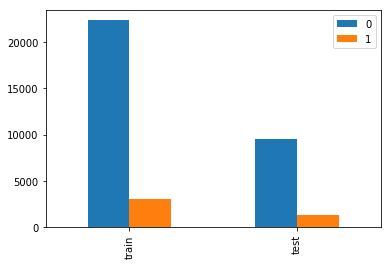

In [6]:
train_1 = (Y_train == 1).sum()
train_0 = (Y_train == 0).sum()
test_1 = (Y_test == 1).sum()
test_0 = (Y_test == 0).sum()
c = pd.DataFrame({'0':[train_0,test_0],'1':[train_1,test_1]},index = ['train', 'test'])
c.plot(kind = 'bar')
plt.show()

In [ ]:
lr = LogisticRegression(C = 1000, tol = 1e-5, class_weight={0:1,1:4}, solver= 'saga', max_iter = 1000)

In [ ]:
mlp = MLPClassifier(alpha=0.01, hidden_layer_sizes=(150, 60), max_iter=2000, random_state=9)

In [ ]:
rf = RandomForestClassifier(n_estimators = 3000, oob_score = True, n_jobs = 3, random_state=9, class_weight='balanced',
                           max_depth=15, max_features=4, min_samples_split=80)

In [ ]:
svc1 = svm.SVC(probability = True, class_weight = 'balanced', C=10000.0, degree=2, kernel='poly')

In [ ]:
svc2 = svm.SVC(probability = True, class_weight = 'balanced', C=10000.0, gamma=0.01, kernel='rbf')

In [ ]:
abc = AdaBoostClassifier(n_estimators=3000, random_state=9, learning_rate=0.02)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators = 3000, learning_rate=0.01, max_leaf_nodes=8, subsample=0.7)

In [ ]:
lr_meta = LogisticRegression(C = 1000, tol = 1e-5, solver= 'saga', max_iter = 1000)

In [9]:
class BlendingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        
    def fit(self, X, y):
        self.base_models_ = [clone(x) for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9, stratify=y)
        
        test_predictions = np.zeros((x_test.shape[0], len(self.base_models_)))
        for i, model in enumerate(self.base_models_):
            model.fit(x_train, y_train)
            test_predictions[:,i] = model.predict_proba(x_test)[:,1]
        self.meta_model_.fit(test_predictions, y_test)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([model.predict_proba(X)[:,1] for model in self.base_models_])
        return self.meta_model_.predict(meta_features)
    
    
    def predict_proba(self, X):
        meta_features = np.column_stack([model.predict_proba(X)[:,1] for model in self.base_models_])
        return self.meta_model_.predict_proba(meta_features)
    



   

In [ ]:
blended_averaged_models = BlendingAveragedModels(base_models = (lr, mlp, rf, svc1, svc2, abc, gbc),
                                                 meta_model = lr_meta)

In [ ]:
blended_averaged_models.fit(X_train,Y_train)

In [ ]:
joblib.dump(blended_averaged_models, 'blend.pkl')

In [10]:
clf = joblib.load( 'blend.pkl')

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
confusion_matrix(Y_train, clf.predict(X_train))

array([[21919,   410],
       [ 1971,  1115]], dtype=int64)

In [13]:
confusion_matrix(Y_test, clf.predict(X_test))

array([[9345,  225],
       [ 867,  456]], dtype=int64)

In [14]:
from sklearn.metrics import classification_report

In [15]:
print(classification_report(Y_train, clf.predict(X_train)))

             precision    recall  f1-score   support

        0.0       0.92      0.98      0.95     22329
        1.0       0.73      0.36      0.48      3086

avg / total       0.89      0.91      0.89     25415



In [16]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.92      0.98      0.94      9570
        1.0       0.67      0.34      0.46      1323

avg / total       0.89      0.90      0.89     10893



In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
roc_auc_score(Y_train, clf.predict_proba(X_train)[:,1],average = 'micro')

0.8898498684333765

In [19]:
roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1],average = 'micro')

0.8437328954570333